# Своя [PROXY](https://github.com/abhinavsingh/proxy.py?tab=readme-ov-file) (VPN для бедных)

## В чём разница?

Если коротко, то зависит от настроек. VPN прям  очень хорошо шифрует трафик by default. А вот с прокси могут быть опции. Если это [http proxy](https://www.fortinet.com/resources/cyberglossary/proxy-vs-vpn#:~:text=Proxy%20servers%20serve%20as%20a,so%20they%20cannot%20be%20identified.) (а именно такой, самый простой пример тут), заподозрить прокси не составит товарищу майору. Однако содержимое, если вы подключаетесь к https сайту (s &ndash; значит secure), останется для него загадкой. Но! конечная цель трафика будет видна (то есть будет известно кто и куда, но неизвестно что). Если это [https трафик](https://habr.com/ru/articles/687512/), товарищ майор сможет установить что это прокси только [косвенными методами](https://habr.com/ru/companies/cloud4y/articles/793670/), например [статистическим анализом трафика](https://ru.wikipedia.org/wiki/Deep_packet_inspection). Наконец, широкоизвестный [shadowsocks](https://habr.com/ru/articles/506356/), созданный как ответ на великий китайский firewall поможет надёжно замаскировать ваш трафик (но всё ещё не сделает вас полностью анонимными, если, скажем, вы всё время будете подключаться [к одному и тому же прокси-серверу](https://www.webscrapingapi.com/web-scraping-rotating-proxies)). [Наша прокси](https://scrapingant.com/blog/python-proxy-server-proxy-py) умеет всё &ndash; главное разобраться с плагинами.

## Prerequisites

1. Установить написанный на `python3` прокси сервер через `pip`
2. Установить утилиту `sshpass`, чтобы автоматизировать процесс ввода пароля от ssh-сервера

In [ ]:
%%bash

pip install proxy.py
sudo apt install -y sshpass

## Использование

Запускаем прокси-сервер в фоновом режиме спомощью python multiprocessing. Сервер поднимется на локалхосте (`127.0.0.1`) на `8899` порту.

In [3]:
import subprocess
import multiprocessing
import time

def server():
    subprocess.call(["proxy", "--hostname", "0.0.0.0"])

p = multiprocessing.Process(target=server)
p.start()

## Создание обратного туннеля

Теперь, согласно схеме, нам надо сделать jupyter notebook из google colab, живущий в своей локальной сети доступным world-wide. Для этого создадим обратный ssh туннель на openssh-server (который нужно поднять у себя на компьютере, инструкция для этого ниже). Вместо `<your-server-password>` подставьте пароль от поднятого вами openssh сервера, вместо `<ssh-port>` &ndash; порт на котором он доступен (проброшенный порт роутера), `<ssh-user>` замените на имя пользователя созданного на openssh сервере и, наконец, `<ssh-host>` на ip адресс вашего роутера (об этом тоже ниже).

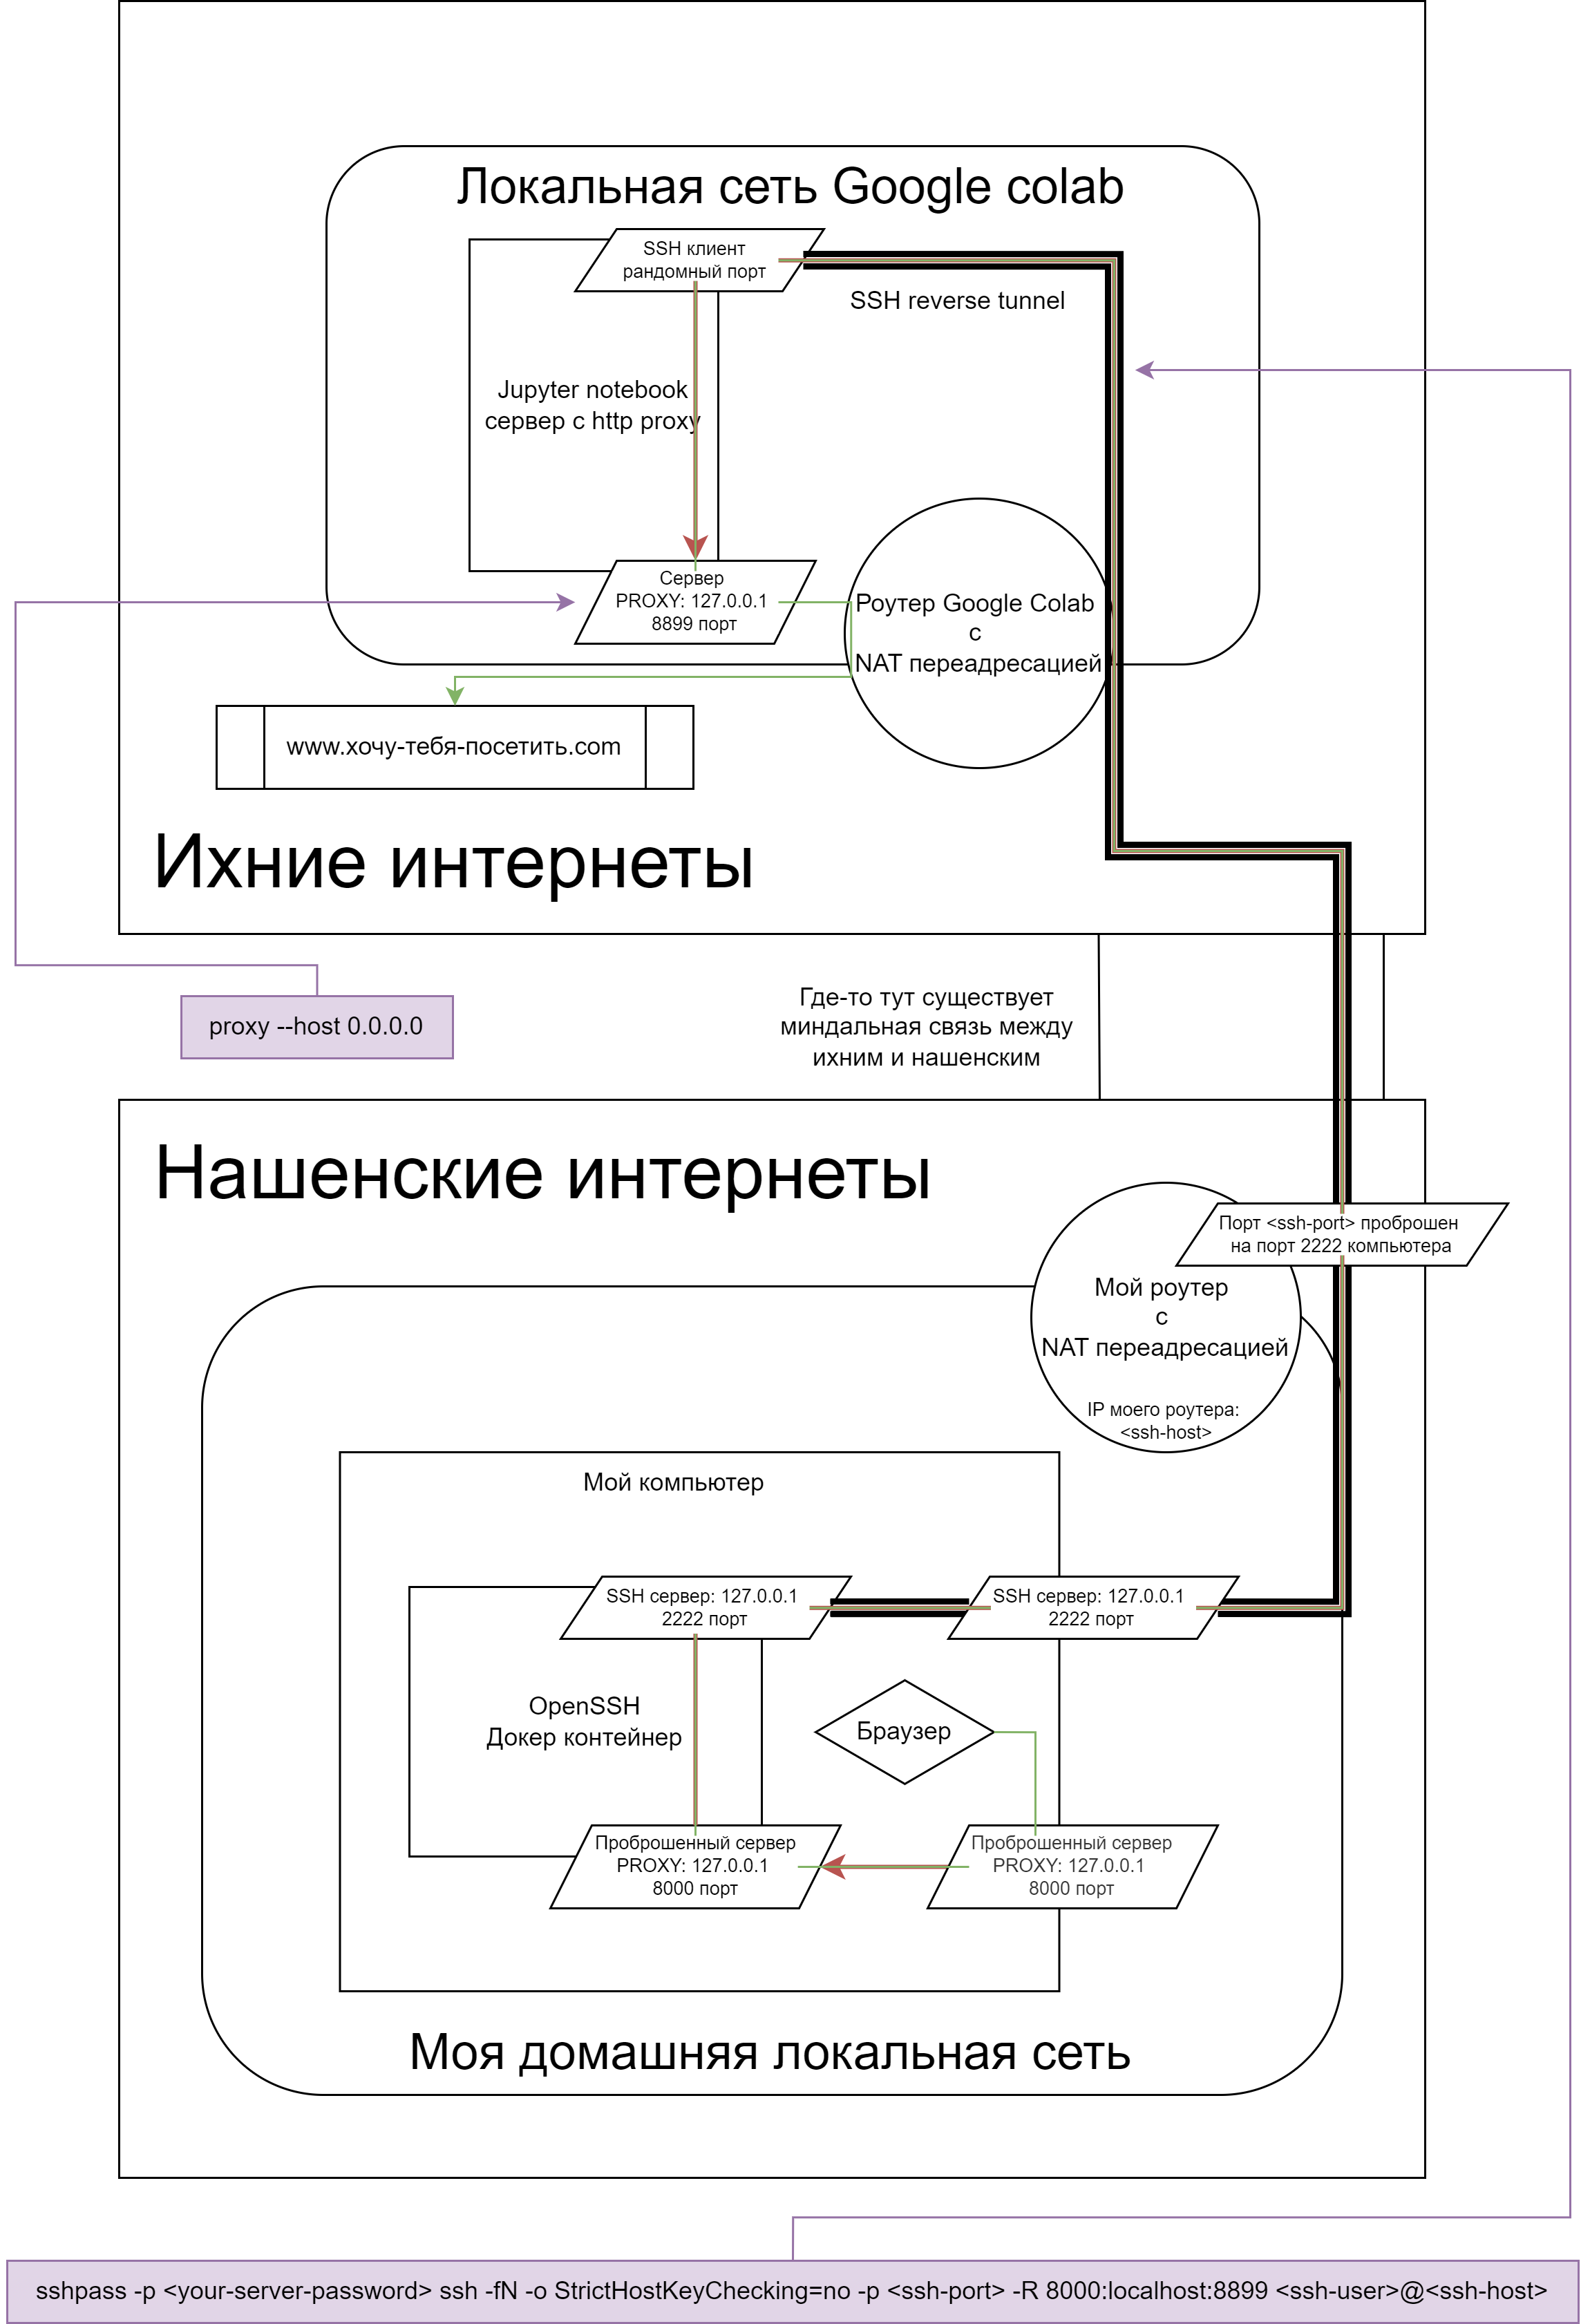

<br><center><i>схему можно и нужно приближать, чтобы рассмотреть надписи</i></center>

In [ ]:
%%bash

sshpass -p <your-server-password> ssh -fN -o StrictHostKeyChecking=no -p <ssh-port> -R 8000:localhost:8899 <ssh-user>@<ssh-host>

## Подготовка компьютера

### Prerequisites

1. Установить [Docker](https://docs.docker.com/engine/install/)
2. Для windows: если потребуется &ndash; установить [wsl](https://learn.microsoft.com/en-us/windows/wsl/install) (может не потребоваться)
3. Скачать образ OpenSSH сервера командой `docker pull lscr.io/linuxserver/openssh-server`

### Запуск OpenSSH сервера

Вместо `<your-server-password>` напишите придуманный вами пароль для openssh сервера, а `<ssh-user>` замените на имя пользователя которое вы придумали для openssh сервера. Опции `-e` передают переменные окружения внутрь докер-контенера, опция `-v` подключает к файловой системе докер-контейнера папку из текущей файловой системы. На windows запускайте нижеприведённый код из wsl и делайте это с осторожностью: если что-то не получится, посмотрите [эту статью](https://superuser.com/questions/1051520/docker-windows-container-how-to-mount-a-host-folder-as-data-volume-on-windows). В крайнем случае, если не будет работать, можно глянуть [эту статью](https://jwstanly.com/blog/article/Port+Forwarding+WSL+2+to+Your+LAN/).

In [ ]:
%%bash

mkdir -p config

cat > ./config/init.sh <<"EOF"
init.sh: |
#!/bin/bash
sed -i "s/$(cat /etc/ssh/sshd_config | grep "^AllowTcpForwarding ")/AllowTcpForwarding yes/g" /etc/ssh/sshd_config
sed -i "s/$(cat /etc/ssh/sshd_config | grep "^GatewayPorts ")/GatewayPorts yes/g" /etc/ssh/sshd_config
EOF

docker run -d --name=openssh-server -e SUDO_ACCESS=true -e PASSWORD_ACCESS=true -e USER_PASSWORD=<your-server-password> -e USER_NAME=<ssh-user> -p 2222:2222 -p 8000:8000 -v "$(pwd)/config:/custom-cont-init.d" lscr.io/linuxserver/openssh-server:latest

### Проброс порта

Зайдите в настройки вашего роутера (обычно http://192.168.0.1 или http://192.168.1.1), введя пароль (смотрите пароль по-умолчанию на роутере, обычно он бывает admin) и настройте переадресацию порта (port-forwarding/virtual servers). Там же можно узнать IP роутера. Для роутеров, поддерживающих DynamicDNS лучше использовать его. Вот пример на моём роутере:

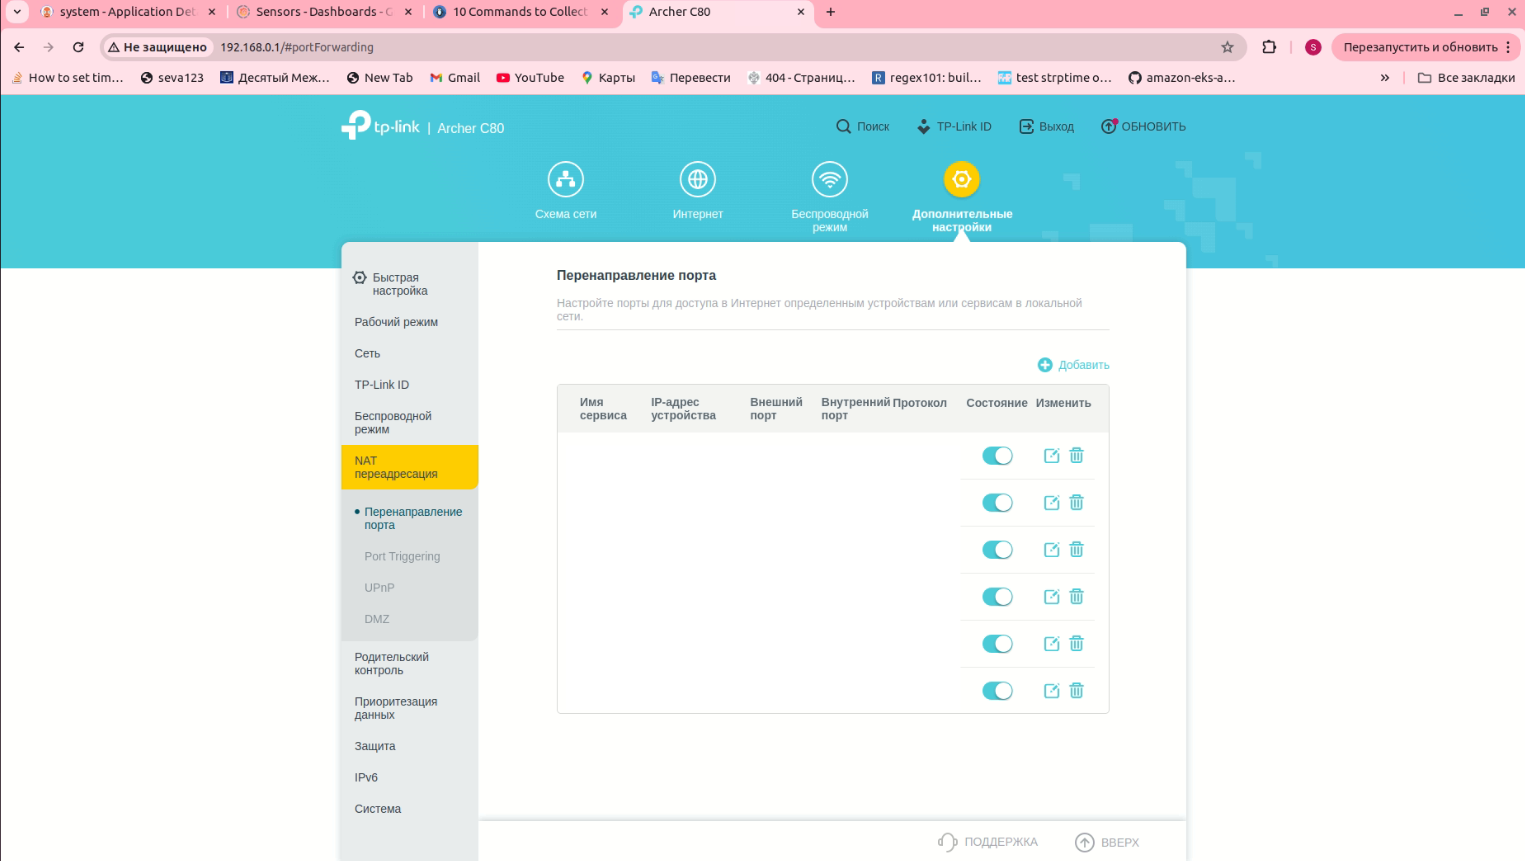

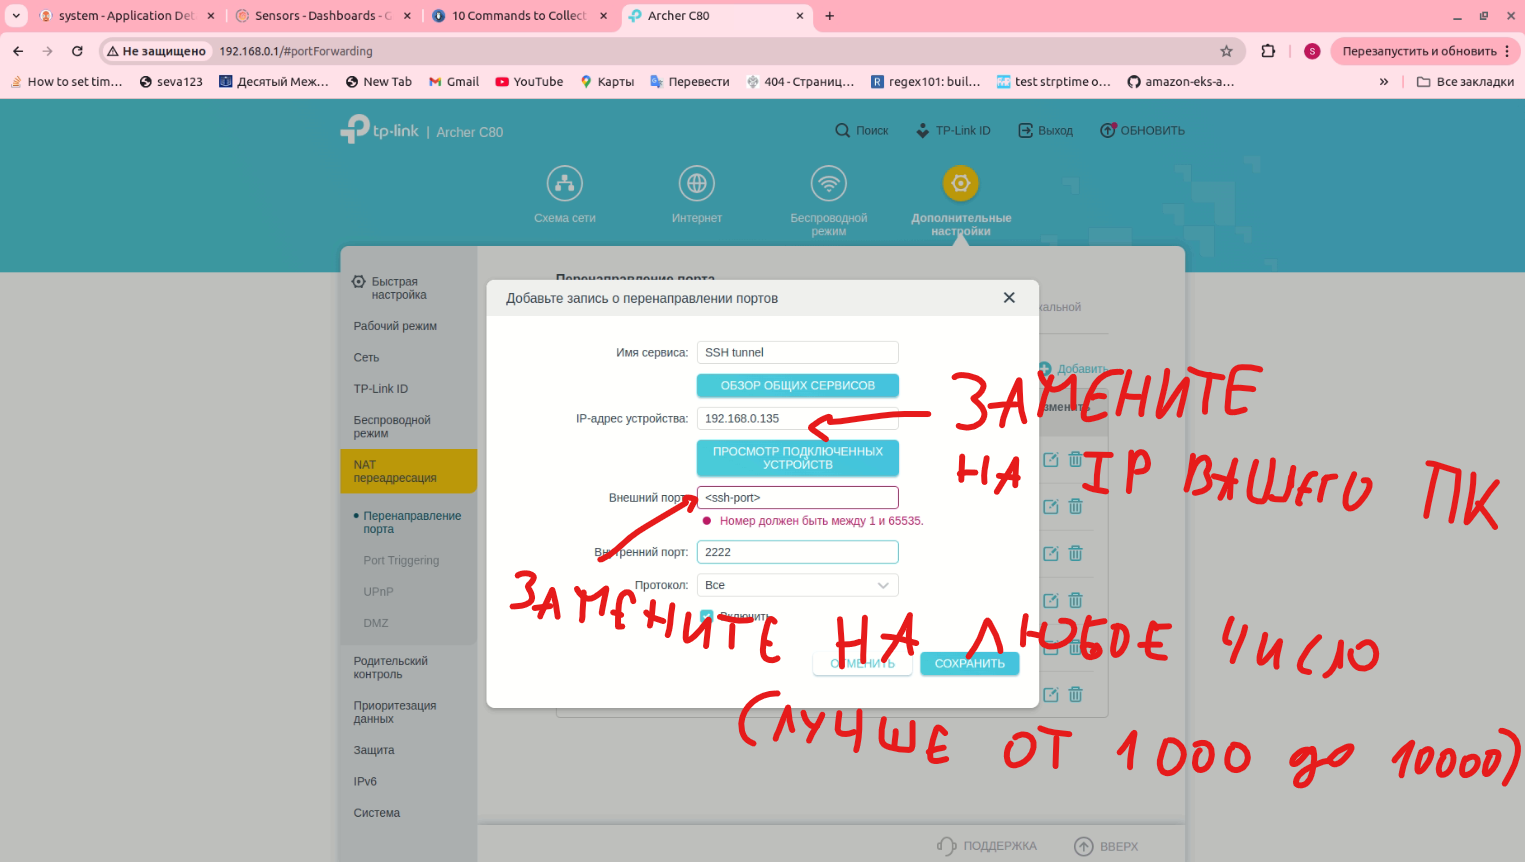

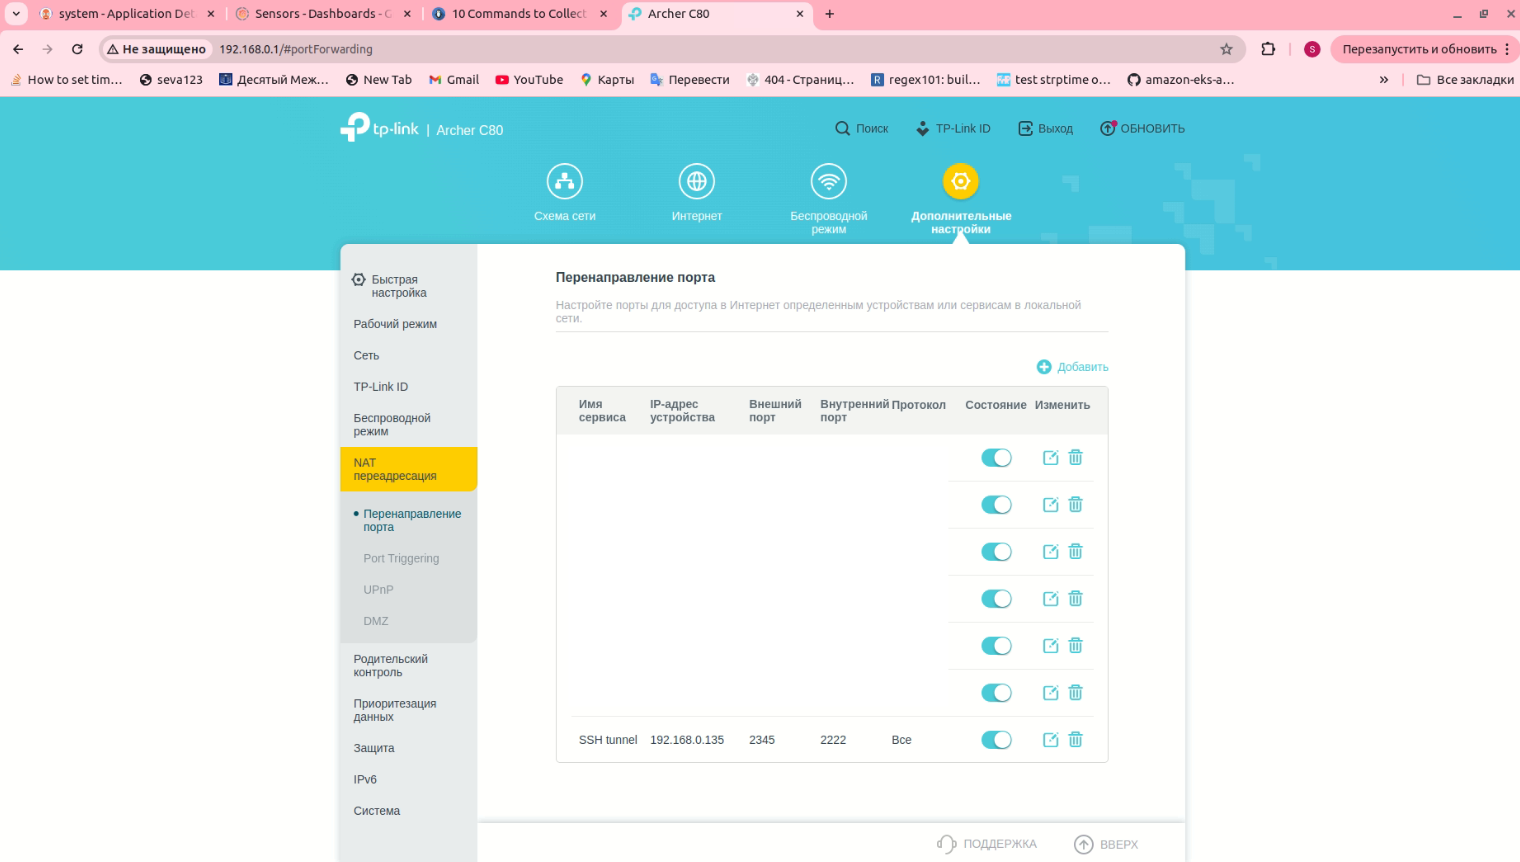

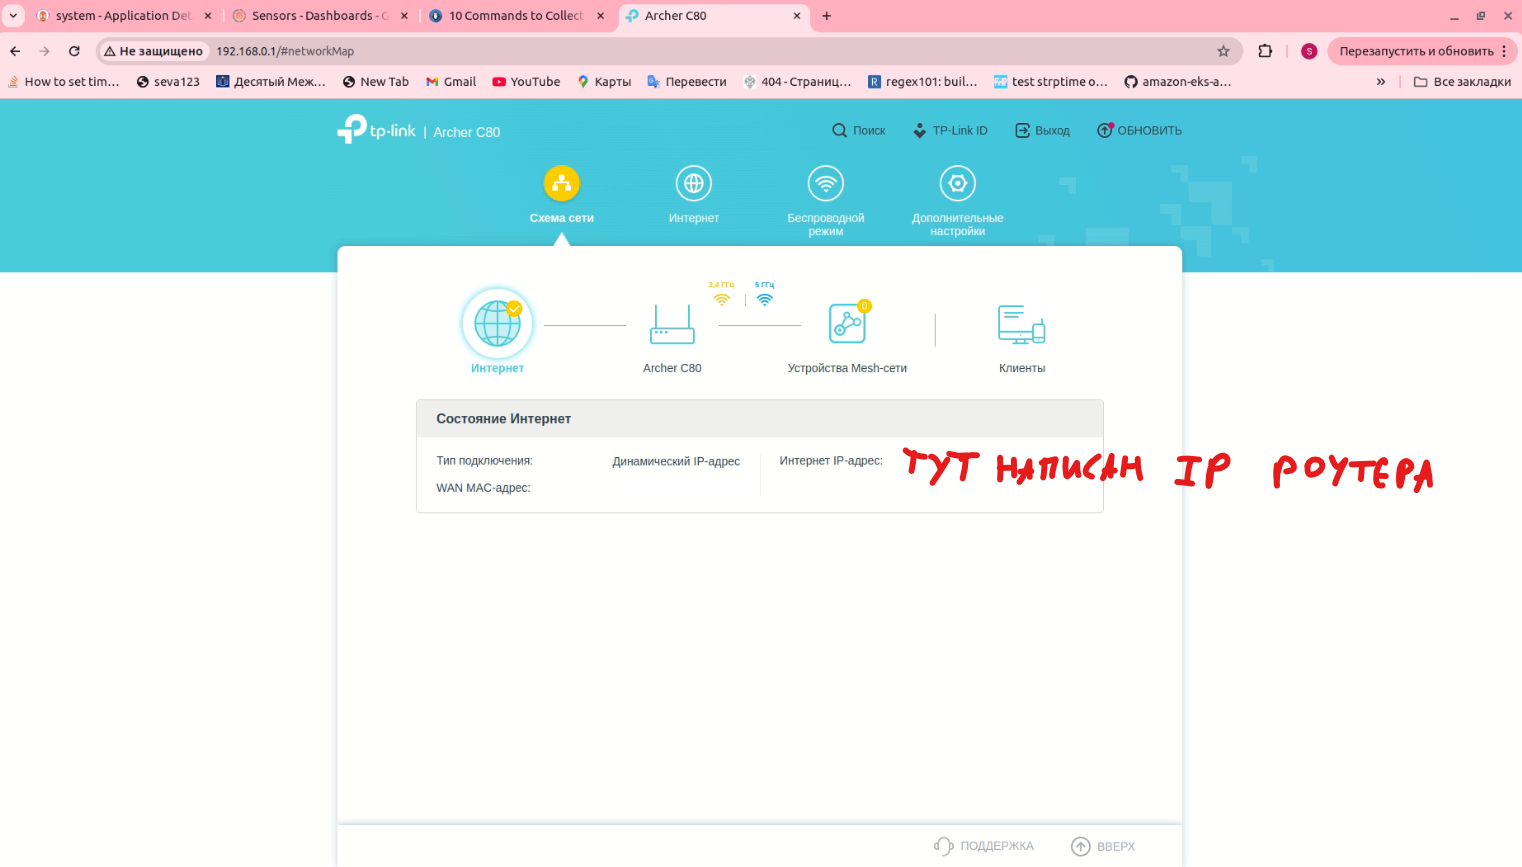

### Настройка proxy

Зависит от операционной системы. Ключевые слова &ndash; "manual proxy setup". Вам нужно указать только ip и порт: 127.0.0.1 и 8000 соответственно. [Например для windows 10](https://www.dummies.com/article/technology/computers/operating-systems/windows/windows-10/how-to-set-up-a-proxy-in-windows-10-140262/). Можно потестить из командной строки: `curl -x 127.0.0.1:8000 google.com -I`.